In [1]:
import os
import dotenv
import pickle
import pandas as pd
import numpy as np

import catboost as cb
import shap
shap.initjs()

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [7]:
X_cb = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/X_catboost.csv', encoding='utf-8')
X_dt = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/X_decision_trees.csv', encoding='utf-8')
y = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/y_both.csv', encoding='utf-8')
y_log = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/y_log_both.csv', encoding='utf-8')

In [8]:
X_cb = X_cb.set_index('ID')
X_cb['topic_lda'] = X_cb.topic_lda.astype(str)
X_cb['bert_keywords'] = X_cb.bert_keywords.fillna('')
X_dt = X_dt.set_index('ID')
y = y.set_index('ID')
y_log = y_log.set_index('ID')

In [32]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_cb, y_log, test_size=0.2, random_state=42, stratify=X_cb['fanpage_id'])

In [33]:
X_train_2, X_test_2, y_train_2, y_test_2 =  train_test_split(X_dt, y_log, test_size=0.2, random_state=42, stratify=X_dt['fanpage_id'])

In [34]:
data_pool_train = cb.Pool(data=X_train_1.drop(columns=['fanpage_id']), label=y_train_1.squeeze(), cat_features=['bert_keywords', 'topic_lda', 'week_posted', 'day_posted', 'hour_posted', 'minute_posted', 'weekday_posted'])
data_pool_test = cb.Pool(data=X_test_1.drop(columns=['fanpage_id']), label=y_test_1.squeeze(), cat_features=['bert_keywords', 'topic_lda', 'week_posted', 'day_posted', 'hour_posted', 'minute_posted', 'weekday_posted'])

In [35]:
X_train_2 = X_train_2.drop(columns=['fanpage_id'])
X_test_2 = X_test_2.drop(columns=['fanpage_id'])
y_train_2 = y_train_2.squeeze()
y_test_2 = y_test_2.squeeze()

In [13]:
# Load the model
with open(os.path.join('/home/jovyan/git_projects/machine-learning-project/models', 'decision_tree_model.pkl'), 'rb') as file:
    dt_m = pickle.load(file)

In [14]:
# Load the model
cb_m = cb.CatBoostRegressor()
cb_m.load_model(os.path.join('/home/jovyan/git_projects/machine-learning-project/models', 'catboost_model.bin'))

# Decision Tree Model

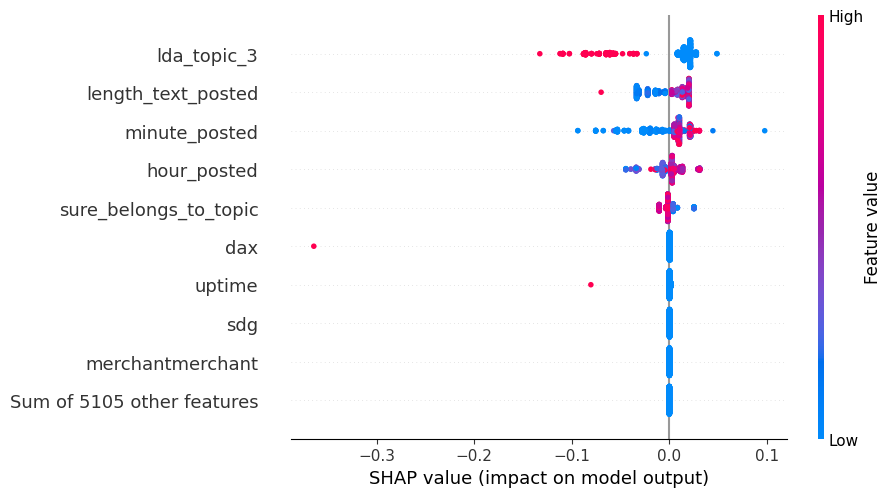

In [91]:
#Create explainer and shap values from model
explainer = shap.Explainer(dt_m)
shap_values = explainer(X_test_2)

#Plot shap beesworm
shap.plots.beeswarm(shap_values)

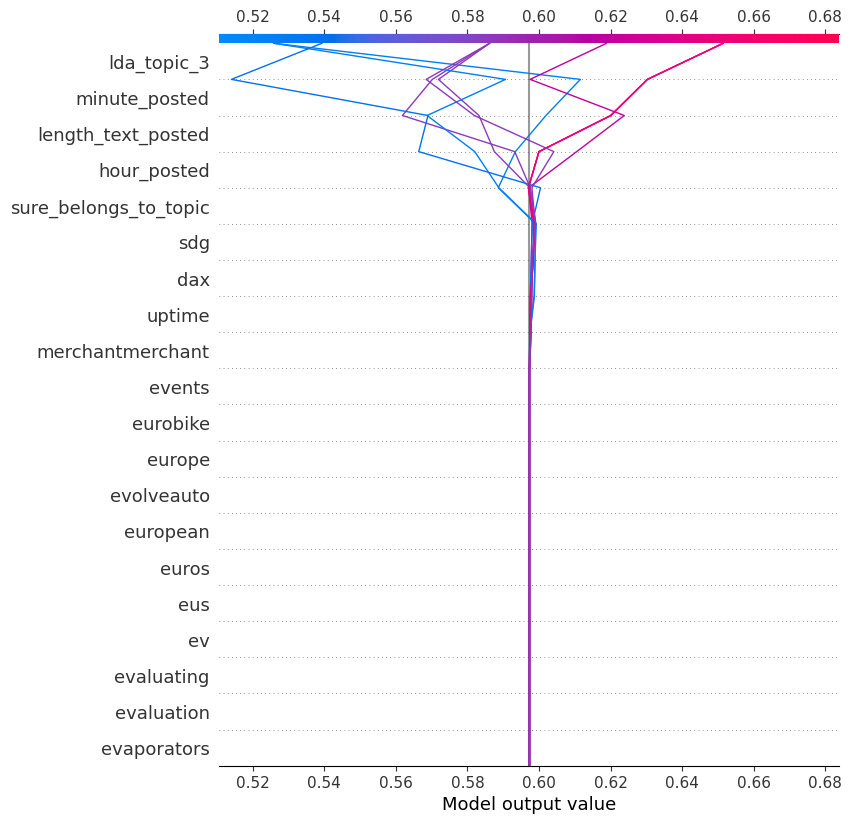

In [92]:
#Plot shap decision tree
expected_values = explainer.expected_value
shap_array = explainer.shap_values(X_test_2)

shap.decision_plot(expected_values, shap_array[0:10],feature_names=list(X_test_2))

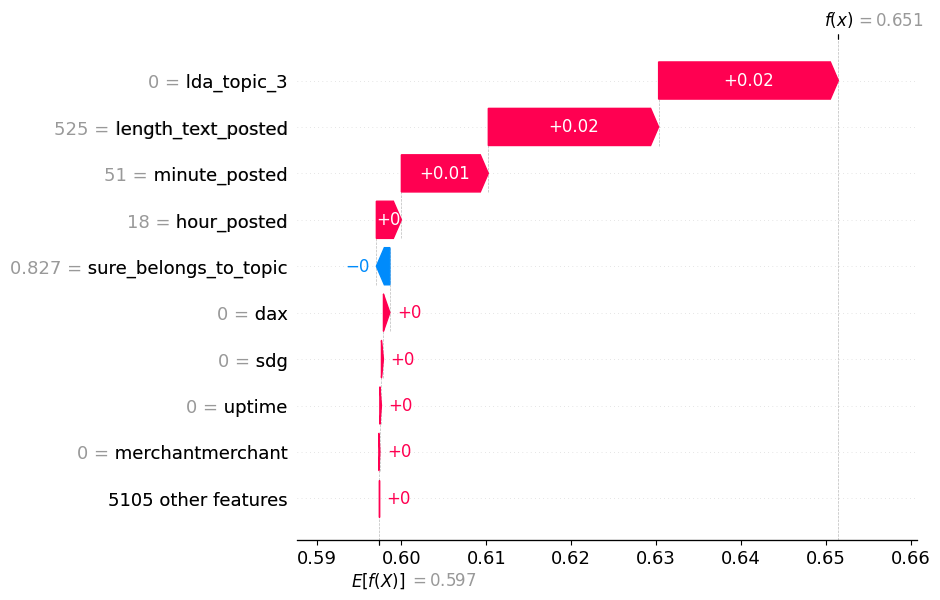

In [93]:
shap.plots.waterfall(shap_values[-1])

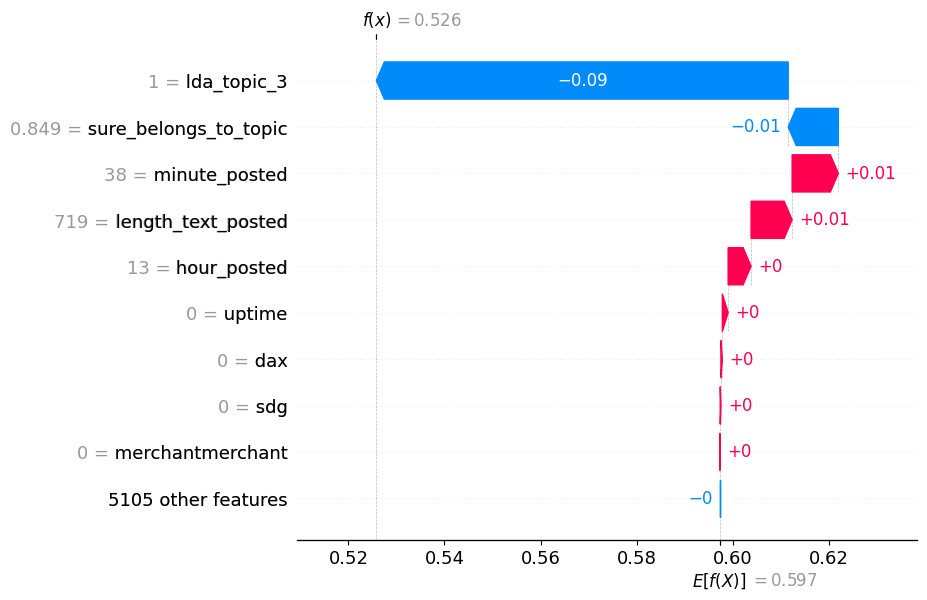

In [94]:
shap.plots.waterfall(shap_values[0])

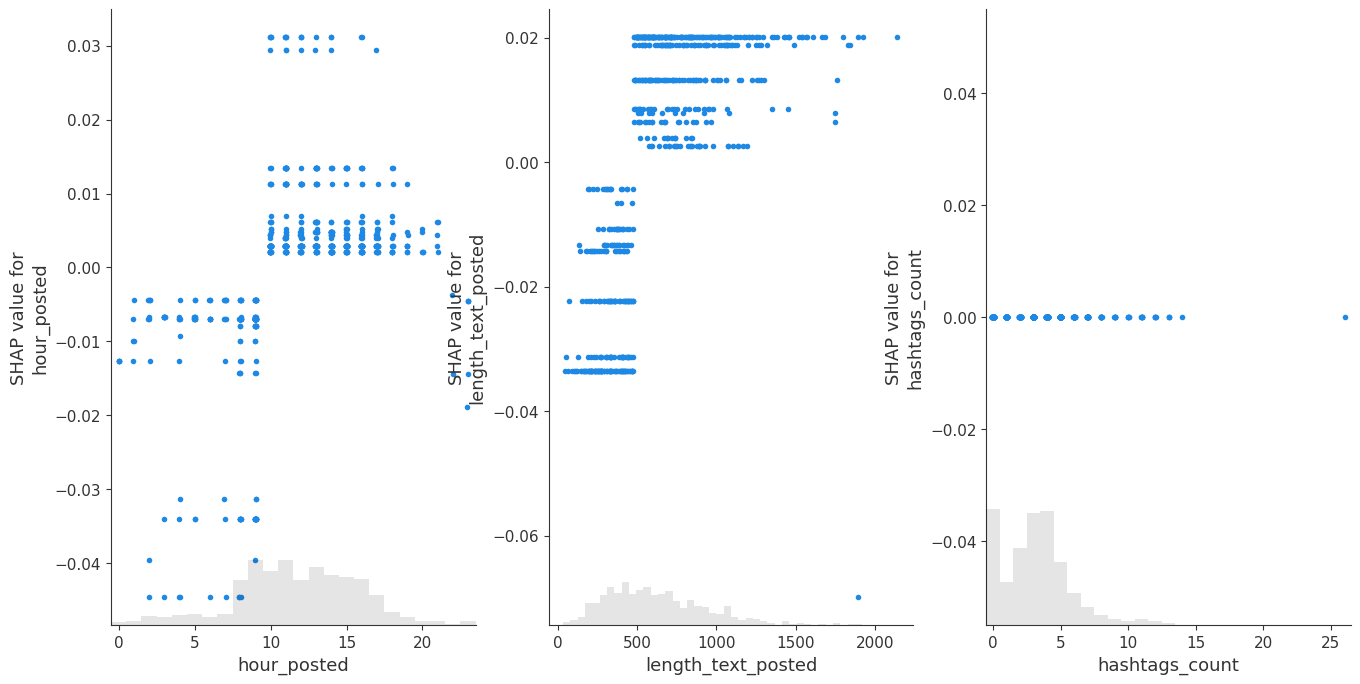

In [96]:
#Create shap scatterplots for important features
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(16,8))

#SHAP scatter plots
shap.plots.scatter(shap_values[:,"hour_posted"],ax=ax[0],show=False)
shap.plots.scatter(shap_values[:,"length_text_posted"],ax=ax[1], show=False)
shap.plots.scatter(shap_values[:,"hashtags_count"],ax=ax[2])

# Catboost Model

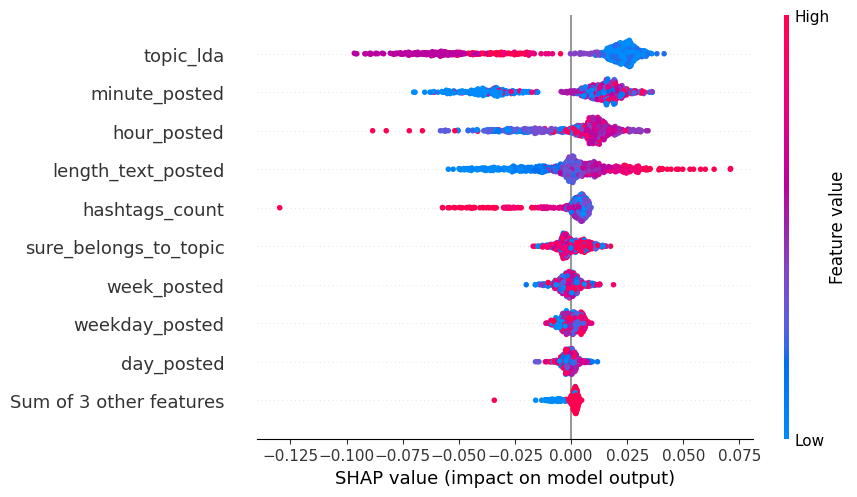

In [97]:
#Create explainer and shap values from model
explainer = shap.Explainer(cb_m)
shap_values = explainer(X_test_1.drop(columns=['fanpage_id']))

#Plot shap beesworm
shap.plots.beeswarm(shap_values)

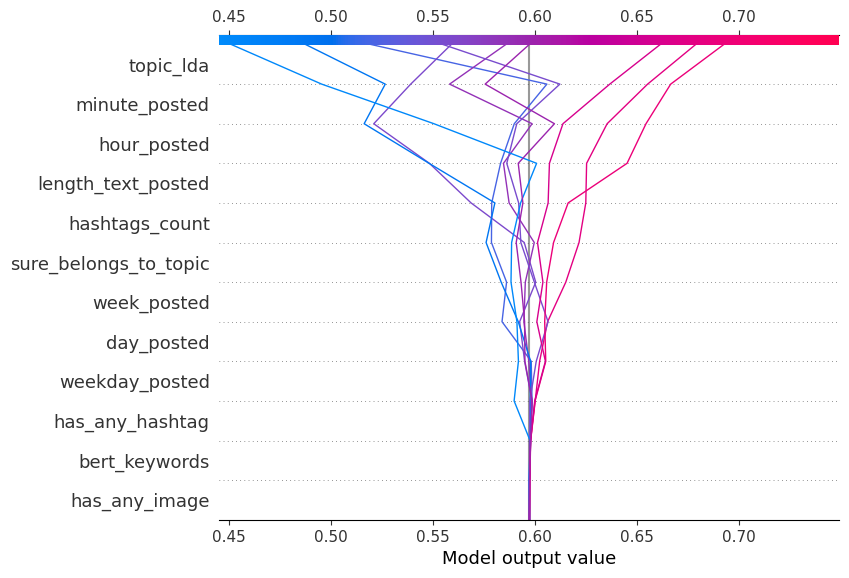

In [98]:
#Plot shap decision tree
expected_values = explainer.expected_value
shap_array = explainer.shap_values(X_test_1.drop(columns=['fanpage_id']))

shap.decision_plot(expected_values, shap_array[0:10],feature_names=list(X_test_1.drop(columns=['fanpage_id'])))

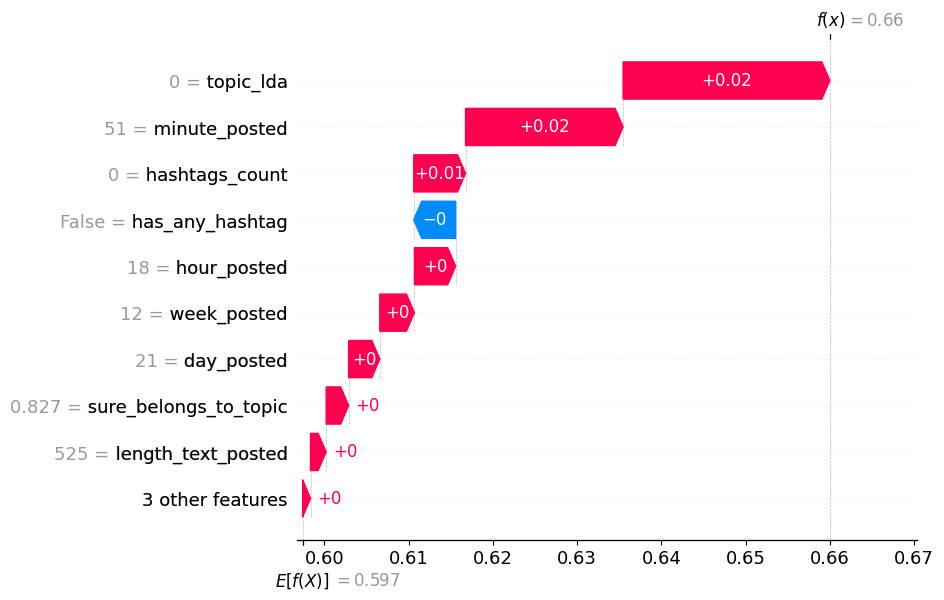

In [99]:
shap.plots.waterfall(shap_values[-1])

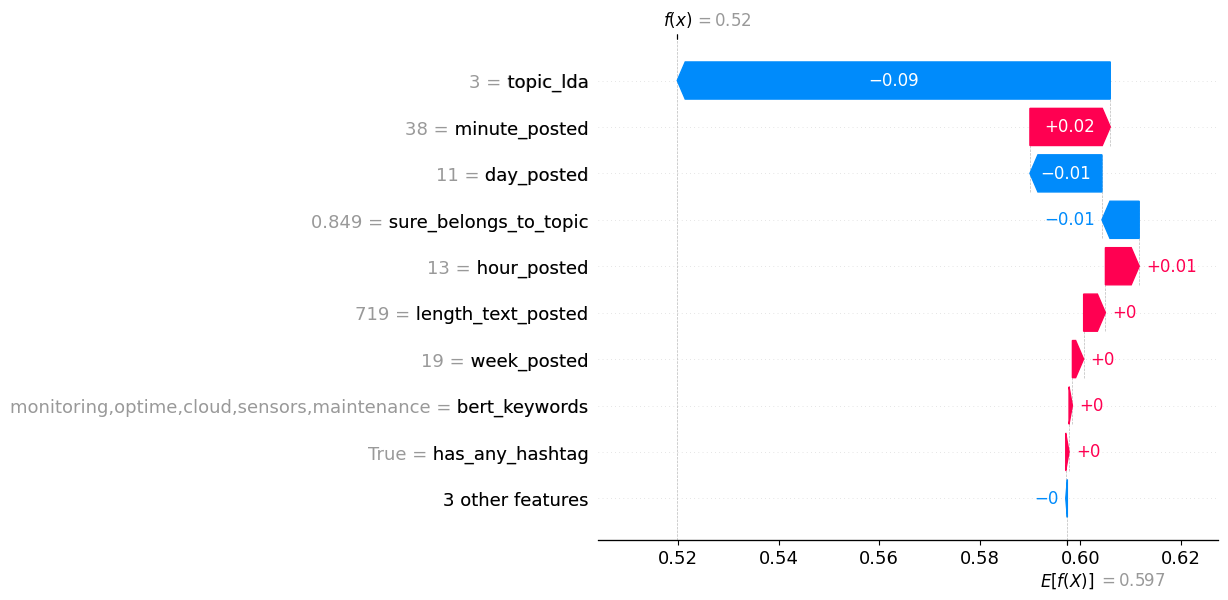

In [100]:
shap.plots.waterfall(shap_values[0])

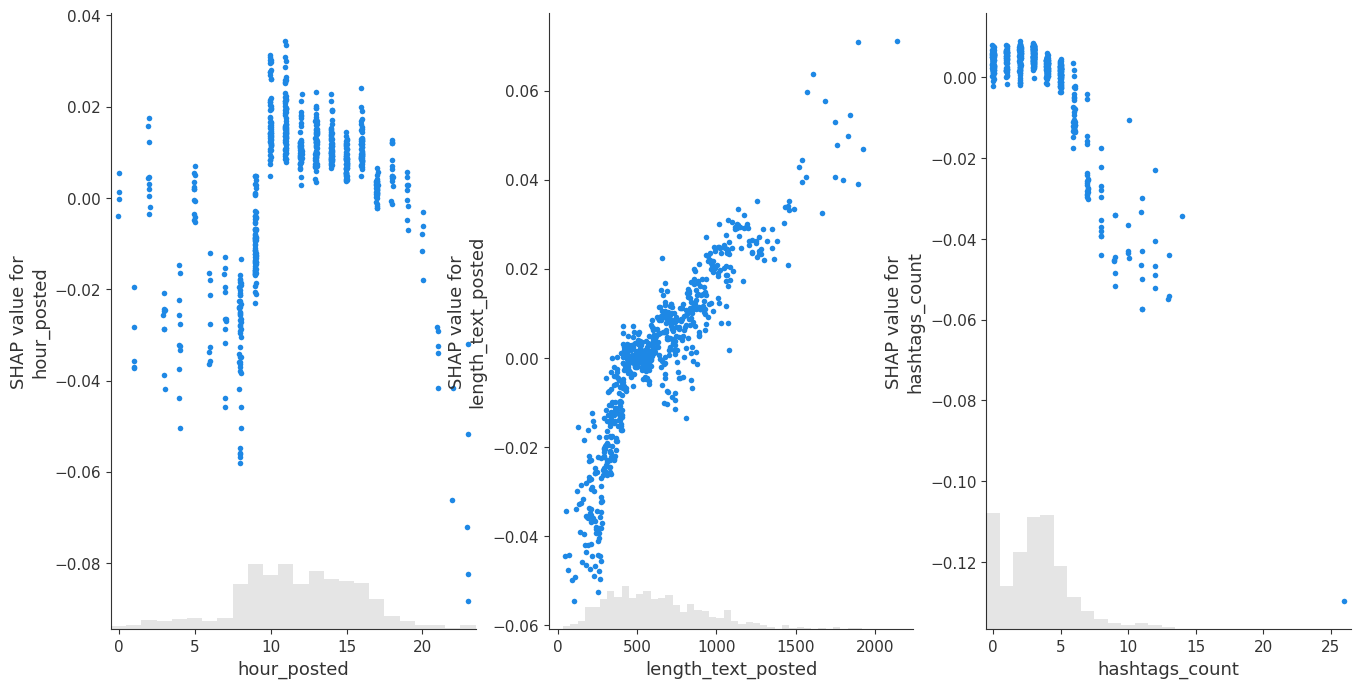

In [101]:
#Create shap scatterplots for important features
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(16,8))

#SHAP scatter plots
shap.plots.scatter(shap_values[:,"hour_posted"],ax=ax[0],show=False)
shap.plots.scatter(shap_values[:,"length_text_posted"],ax=ax[1], show=False)
shap.plots.scatter(shap_values[:,"hashtags_count"],ax=ax[2])

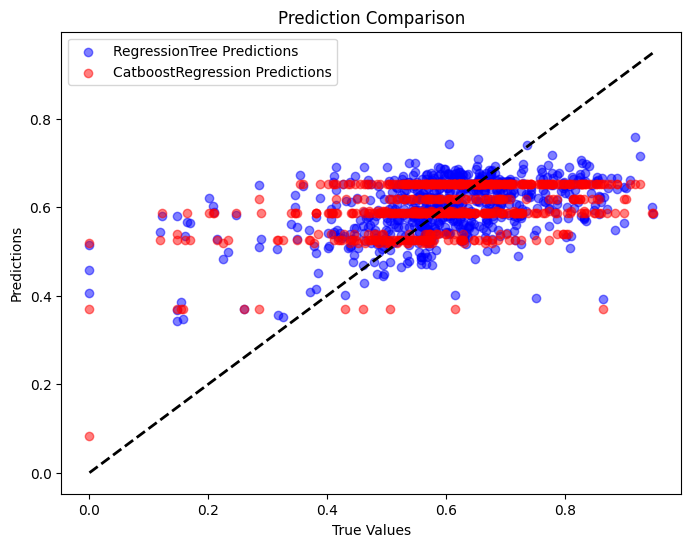

In [102]:
# Prediction Comparison Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, cb_m.predict(X_test_1.drop(columns=['fanpage_id'])), color='blue', alpha=0.5, label='RegressionTree Predictions')
plt.scatter(y_test, dt_m.predict(X_test_2), color='red', alpha=0.5, label='CatboostRegression Predictions')
plt.plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], color='black', linestyle='--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction Comparison')
plt.legend()
plt.show()